# **Computer Vision Project -  Recognizing Objects in Video Sequences**

**Course**: Computer Vision Project (DLBAIPCV01)

**Task:** Recognizing Objects in Video Sequences

**Student**: Lisa van der Linden

**Matriculation** 9218894

**BSc Applied Artifical Intelligence**

**International University of Applied Sciences**

**Project task:**
Develop a computer vision system that takes as input a video sequence and returns the same showing the position, shape and name of the objects present in the video. Evaluate three SoA approaches, with respect to validity, reliability and objectivity on one
representative dataset. At the end of
this evaluation, present the best SoA system in a video sequence






**Step 1. Setting up the environment**

In [ ]:
# Install required dependencies
!pip install ultralytics
!pip install torch torchvision
!pip install opencv-python
!pip install matplotlib pandas seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
# Import libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from tqdm import tqdm
import urllib.request
import zipfile
import time
import random
import seaborn as sns
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from IPython.display import display, HTML


In [ ]:
# Create local project directories for data storage
project_path = '/content/ObjectDetectionProject'
os.makedirs(project_path, exist_ok=True)

data_path = os.path.join(project_path, 'data')
results_path = os.path.join(project_path, 'results')

os.makedirs(data_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)
os.makedirs(os.path.join(results_path, 'videos'), exist_ok=True)
os.makedirs(os.path.join(results_path, 'metrics'), exist_ok=True)
os.makedirs(os.path.join(results_path, 'visualizations'), exist_ok=True)

**Step 2: Download the MOT17Det Dataset**

In [ ]:
# Define the project paths
project_path = '/content/ObjectDetectionProject'
data_path = os.path.join(project_path, 'data')

# Create directories if they don't exist
os.makedirs(data_path, exist_ok=True)

# Correct URL for MOT17Det dataset
mot_url = "https://motchallenge.net/data/MOT17Det.zip"
zip_path = os.path.join(data_path, 'MOT17Det.zip')

# Download
try:
    print(f"Downloading MOT17Det dataset... (this may take a few minutes)")
    start_time = time.time()

    urllib.request.urlretrieve(mot_url, zip_path)

    download_time = time.time() - start_time
    print(f"Download complete in {download_time:.1f} seconds")

    # Check the downloaded file
    if os.path.exists(zip_path):
        file_size = os.path.getsize(zip_path) / (1024 * 1024)  # Convert to MB
        print(f"Downloaded file size: {file_size:.2f} MB")

        # Extract the zip file
        print(f"Extracting MOT17Det.zip to {data_path}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_path)
        print("Extraction complete!")

        # Check the extracted directory structure
        train_dir = os.path.join(data_path, 'train')

        print("Checking dataset structure...")

        if os.path.exists(train_dir):
            print(f"Found 'train' directory at {train_dir}")

            # Count sequences
            train_sequences = [seq for seq in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, seq))]
            print(f"Found {len(train_sequences)} sequences in the training set:")

            for seq in train_sequences:
                seq_path = os.path.join(train_dir, seq)
                img_dir = os.path.join(seq_path, 'img1')
                gt_file = os.path.join(seq_path, 'gt', 'gt.txt')

                # Count images
                num_images = len(os.listdir(img_dir)) if os.path.exists(img_dir) else 0

                # Check ground truth
                gt_exists = "Yes" if os.path.exists(gt_file) else "No"

                print(f"  - {seq}: {num_images} images, Ground truth: {gt_exists}")
        else:
            print("Error: 'train' directory not found after extraction!")
            print("Contents of data directory:")
            print(os.listdir(data_path))

        # Clean up the zip file to save space
        print("Removing the zip file to save space...")
        os.remove(zip_path)
        print("MOT17Det dataset download and extraction completed successfully!")

except Exception as e:
    print(f"Error downloading or extracting dataset: {e}")
    print("\nIf the automatic download failed, you can:")
    print("1. Download the dataset manually from https://motchallenge.net/data/MOT17Det.zip")
    print(f"2. Upload it to Colab and extract it to {data_path}")
    print("3. Continue with the notebook execution")

Download complete in 96.7 seconds
Downloaded file size: 1862.09 MB
Extracting MOT17Det.zip to /content/ObjectDetectionProject/data...
Extraction complete!
Checking dataset structure...
Found 'train' directory at /content/ObjectDetectionProject/data/train
Found 7 sequences in the training set:
  - MOT17-04: 1050 images, Ground truth: Yes
  - MOT17-10: 654 images, Ground truth: Yes
  - MOT17-13: 750 images, Ground truth: Yes
  - MOT17-09: 525 images, Ground truth: Yes
  - MOT17-05: 837 images, Ground truth: Yes
  - MOT17-11: 900 images, Ground truth: Yes
  - MOT17-02: 600 images, Ground truth: Yes
Removing the zip file to save space...
MOT17Det dataset download and extraction completed successfully!


**Step 3: Explore the dataset structure**

In [ ]:
def explore_mot_dataset(dataset_path):
    """
    Explore the structure of the MOT dataset
    """
    print("Exploring MOT dataset structure...")

    train_path = os.path.join(dataset_path, 'train')

    # Check if the train directory exists
    if not os.path.exists(train_path):
        print(f"Error: 'train' directory not found in {dataset_path}")
        return None

    # List all sequences in the train folder
    sequences = [f for f in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, f))]
    print(f"Found {len(sequences)} sequences in the training set:")

    sequence_info = []

    for seq in sequences:
        seq_path = os.path.join(train_path, seq)
        img_path = os.path.join(seq_path, 'img1')
        gt_path = os.path.join(seq_path, 'gt', 'gt.txt')

        # Count number of images
        num_images = len(os.listdir(img_path)) if os.path.exists(img_path) else 0

        # Get image dimensions
        if num_images > 0:
            sample_img = os.path.join(img_path, os.listdir(img_path)[0])
            img = cv2.imread(sample_img)
            if img is not None:
                height, width, _ = img.shape
            else:
                height, width = "N/A", "N/A"
        else:
            height, width = "N/A", "N/A"

        # Count number of annotations
        num_annotations = 0
        num_unique_objects = 0
        if os.path.exists(gt_path):
            with open(gt_path, 'r') as f:
                lines = f.readlines()
                num_annotations = len(lines)

                # Count unique objects
                object_ids = set()
                for line in lines:
                    data = line.strip().split(',')
                    if len(data) > 1:
                        object_ids.add(int(data[1]))
                num_unique_objects = len(object_ids)

        sequence_info.append({
            'Sequence': seq,
            'Images': num_images,
            'Resolution': f"{width}x{height}" if width != "N/A" else "N/A",
            'Annotations': num_annotations,
            'Unique Objects': num_unique_objects
        })

    # Create a DataFrame for better visualization
    df = pd.DataFrame(sequence_info)
    print(df.to_string(index=False))

    return df

# Execute the exploration function
sequence_df = explore_mot_dataset(data_path)

Exploring MOT dataset structure...
Found 7 sequences in the training set:
Sequence  Images Resolution  Annotations  Unique Objects
MOT17-04    1050  1920x1080       108005             141
MOT17-10     654  1920x1080        17450              73
MOT17-13     750  1920x1080        20202             188
MOT17-09     525  1920x1080        10411              64
MOT17-05     837    640x480         8013             156
MOT17-11     900  1920x1080        10617              91
MOT17-02     600  1920x1080        30003              83


**Step 4 Prepare dataset for evaluation**



In [ ]:
def parse_ground_truth(gt_file, frame_id, frame_width, frame_height):
    """
    Parse ground truth from MOT format for a specific frame
    Returns: list of [x1, y1, x2, y2, class_id, confidence]
    """
    ground_truths = []

    with open(gt_file, 'r') as f:
        for line in f:
            data = line.strip().split(',')
            if len(data) >= 7 and int(data[0]) == frame_id:
                # Convert to [x1, y1, x2, y2, class_id, confidence]
                x1 = float(data[2])
                y1 = float(data[3])
                w = float(data[4])
                h = float(data[5])
                class_id = int(data[7]) if len(data) > 7 else 1  # Default to person (1) if class not specified
                confidence = float(data[6])

                # Clip to image boundaries
                x1 = max(0, min(frame_width - 1, x1))
                y1 = max(0, min(frame_height - 1, y1))
                x2 = max(0, min(frame_width - 1, x1 + w))
                y2 = max(0, min(frame_height - 1, y1 + h))

                ground_truths.append([x1, y1, x2, y2, class_id, confidence])

    return ground_truths

def load_sequence_frames(sequence_path, start_frame=1, end_frame=None, stride=1):
    """
    Load frames from a MOT sequence
    Returns: list of frames
    """
    img_path = os.path.join(sequence_path, 'img1')

    if not os.path.exists(img_path):
        print(f"Error: Image path not found at {img_path}")
        return [], []

    # Get all image files
    all_files = sorted([f for f in os.listdir(img_path) if f.endswith('.jpg')])

    if end_frame is None:
        end_frame = len(all_files)
    else:
        end_frame = min(end_frame, len(all_files))

    frames = []
    frame_ids = []

    for i in range(start_frame-1, end_frame, stride):
        if i < len(all_files):
            frame_path = os.path.join(img_path, all_files[i])
            frame = cv2.imread(frame_path)
            if frame is not None:
                frames.append(frame)
                # Extract frame ID from filename (e.g., "000001.jpg" -> 1)
                frame_id = int(os.path.splitext(all_files[i])[0])
                frame_ids.append(frame_id)

    return frames, frame_ids

def select_evaluation_sequence(dataset_path, selected_sequence=None):
    """
    Select a sequence for evaluation
    """
    train_path = os.path.join(dataset_path, 'train')

    if not os.path.exists(train_path):
        print(f"Error: Train path not found at {train_path}")
        return None, None, None

    sequences = [f for f in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, f))]

    if not sequences:
        print("Error: No sequences found in the train folder")
        return None, None, None

    if selected_sequence is not None and selected_sequence in sequences:
        sequence = selected_sequence
    else:
        # If no sequence is specified, select one with a good number of annotations
        if 'sequence_df' in globals() and sequence_df is not None and not sequence_df.empty:
            sequence = sequence_df.sort_values('Annotations', ascending=False).iloc[0]['Sequence']
        else:
            # If no sequence data is available, select the first sequence
            sequence = sequences[0]

    sequence_path = os.path.join(train_path, sequence)
    gt_path = os.path.join(sequence_path, 'gt', 'gt.txt')

    print(f"Selected sequence: {sequence}")
    print(f"Sequence path: {sequence_path}")
    print(f"Ground truth path: {gt_path}")

    return sequence, sequence_path, gt_path

# Select a sequence for evaluation
try:
    selected_seq, seq_path, gt_file = select_evaluation_sequence(data_path)

    if selected_seq is not None and seq_path is not None:
        # Load a subset of frames for evaluation
        frames, frame_ids = load_sequence_frames(seq_path, start_frame=1, end_frame=None, stride=1)

        print(f"Loaded {len(frames)} frames from sequence {selected_seq}")

        # Get sample frame dimensions
        if len(frames) > 0:
            sample_frame = frames[0]
            frame_height, frame_width, _ = sample_frame.shape
            print(f"Frame dimensions: {frame_width}x{frame_height}")
        else:
            print("No frames were loaded. Check the sequence path and image files.")
    else:
        print("Could not select a valid sequence for evaluation.")
except Exception as e:
    print(f"Error during sequence selection: {e}")

Selected sequence: MOT17-04
Sequence path: /content/ObjectDetectionProject/data/train/MOT17-04
Ground truth path: /content/ObjectDetectionProject/data/train/MOT17-04/gt/gt.txt
Loaded 1050 frames from sequence MOT17-04
Frame dimensions: 1920x1080


**Step 5: Model Implementation - YOLOv8**

In [ ]:
class YOLOv8Detector:
    """
    YOLOv8 implementation for object detection
    """
    def __init__(self, model_size='s'):
        """
        Initialize YOLOv8 model
        model_size: 'n', 's', 'm', 'l', 'x' (from smallest to largest)
        """
        from ultralytics import YOLO

        # Set device for computation
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Initializing YOLOv8-{model_size} model on {self.device}...")

        self.model = YOLO(f'yolov8{model_size}.pt')
        self.name = f"YOLOv8-{model_size}"

        # COCO class mapping (class_id -> name)
        self.class_names = self.model.names

        # YOLOv8 to COCO class mapping
        self.yolo_to_coco = {0: 1}  # Map YOLO person class (0) to COCO person class (1)

        print(f"YOLOv8-{model_size} initialized successfully")

    def detect(self, frame, conf_threshold=0.25):
        """
        Detect objects in a single frame
        Returns: list of [x1, y1, x2, y2, class_id, confidence]
        """
        # Pass the device to the model for inference
        results = self.model(frame, conf=conf_threshold, device=self.device)

        detections = []
        for result in results:
            boxes = result.boxes.xyxy.cpu().numpy()
            confidences = result.boxes.conf.cpu().numpy()
            class_ids = result.boxes.cls.cpu().numpy().astype(int)

            for i, box in enumerate(boxes):
                x1, y1, x2, y2 = box
                # Map YOLO class to COCO class if available, otherwise use original
                coco_class = self.yolo_to_coco.get(class_ids[i], class_ids[i])
                detections.append([x1, y1, x2, y2, coco_class, confidences[i]])

        return detections

# Initialize YOLOv8 model
yolo_detector = YOLOv8Detector(model_size='s')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Initializing YOLOv8-s model on cuda...


100%|██████████| 21.5M/21.5M [00:00<00:00, 122MB/s] 


YOLOv8-s initialized successfully


**Step 6: Model Implementation - Mask R-CNN**

In [ ]:
class MaskRCNNDetector:
    """
    Mask R-CNN implementation for object detection
    """
    def __init__(self, backbone='resnet50'):
        """
        Initialize Mask R-CNN model
        backbone: 'resnet50', 'resnet101'
        """
        print(f"Initializing Mask R-CNN with {backbone} backbone...")

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        if backbone == 'resnet50':
            self.model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(pretrained=True)
        elif backbone == 'resnet101':
            self.model = torchvision.models.detection.maskrcnn_resnet101_fpn(pretrained=True)

        # Move model to the specified device
        self.model.to(self.device)
        self.model.eval()
        self.name = f"MaskRCNN-{backbone}"

        # COCO class names
        self.classes = [
            'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
            'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
            'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
            'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
            'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
            'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
            'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
            'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
            'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
            'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
            'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
            'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
        ]

        print(f"Mask R-CNN initialized successfully on {self.device}")

    def detect(self, frame, conf_threshold=0.5):
        """
        Detect objects in a single frame
        Returns: list of [x1, y1, x2, y2, class_id, confidence]
        """
        # Convert BGR to RGB and normalize
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
        # Move tensor to the correct device
        img_tensor = img_tensor.to(self.device)

        with torch.no_grad():
            predictions = self.model([img_tensor])

        boxes = predictions[0]['boxes'].cpu().numpy()
        scores = predictions[0]['scores'].cpu().numpy()
        labels = predictions[0]['labels'].cpu().numpy()
        masks = predictions[0]['masks'].cpu().numpy()

        # Filter detections with confidence > threshold
        keep = scores > conf_threshold
        boxes = boxes[keep]
        scores = scores[keep]
        labels = labels[keep]
        masks = masks[keep]

        detections = []
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = box
            detections.append([x1, y1, x2, y2, labels[i], scores[i]])

        return detections

# Initialize Mask R-CNN model
maskrcnn_detector = MaskRCNNDetector(backbone='resnet50')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Initializing Mask R-CNN with resnet50 backbone...
Using device: cuda


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:01<00:00, 122MB/s]


Mask R-CNN initialized successfully on cuda


**Step 7: Model Implementation - Faster R-CNN**

In [ ]:
class FasterRCNNDetector:
    """
    Faster R-CNN implementation for object detection
    """
    def __init__(self, backbone='resnet50'):
        """
        Initialize Faster R-CNN model
        backbone: 'resnet50', 'resnet101', 'mobilenet_v3_large'
        """
        print(f"Initializing Faster R-CNN with {backbone} backbone...")

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        if backbone == 'resnet50':
            self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)
        elif backbone == 'resnet101':
            self.model = torchvision.models.detection.fasterrcnn_resnet101_fpn(pretrained=True)
        elif backbone == 'mobilenet_v3_large':
            self.model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

        # Move model to the specified device
        self.model.to(self.device)
        self.model.eval()
        self.name = f"FasterRCNN-{backbone}"

        # COCO class names (same as Mask R-CNN)
        self.classes = [
            'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
            'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
            'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
            'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
            'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
            'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
            'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
            'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
            'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
            'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
            'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
            'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
        ]

        print(f"Faster R-CNN initialized successfully on {self.device}")

    def detect(self, frame, conf_threshold=0.5):
        """
        Detect objects in a single frame
        Returns: list of [x1, y1, x2, y2, class_id, confidence]
        """
        # Convert BGR to RGB and normalize
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
        # Move tensor to the correct device
        img_tensor = img_tensor.to(self.device)

        with torch.no_grad():
            predictions = self.model([img_tensor])

        boxes = predictions[0]['boxes'].cpu().numpy()
        scores = predictions[0]['scores'].cpu().numpy()
        labels = predictions[0]['labels'].cpu().numpy()

        # Filter detections with confidence > threshold
        keep = scores > conf_threshold
        boxes = boxes[keep]
        scores = scores[keep]
        labels = labels[keep]

        detections = []
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = box
            detections.append([x1, y1, x2, y2, labels[i], scores[i]])

        return detections

# Initialize Faster R-CNN model
fasterrcnn_detector = FasterRCNNDetector(backbone='resnet50')

Initializing Faster R-CNN with resnet50 backbone...
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:01<00:00, 98.4MB/s]


Faster R-CNN initialized successfully on cuda


**Step 8: Implement Evaluation Metrics**

In [ ]:
def calculate_iou(box1, box2):
    """
    Calculate IoU between two bounding boxes
    box format: [x1, y1, x2, y2]
    """
    # Calculate intersection area
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Calculate union area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    return intersection_area / union_area

def calculate_precision_recall_f1(predictions, ground_truths, iou_threshold=0.5, print_details=False):
    """
    Calculate precision, recall, and F1 score
    predictions and ground_truths are lists of bounding boxes [x1, y1, x2, y2, class_id, confidence]
    """
    true_positives = 0
    false_positives = 0
    total_iou = 0.0  # To track the sum of IoUs for true positives

    # Make a copy to avoid modifying the original
    remaining_gt = ground_truths.copy()

    for pred in predictions:
        best_iou = 0
        best_gt_idx = -1

        for i, gt in enumerate(remaining_gt):
            # Check if they belong to the same class
            if pred[4] == gt[4]:
                iou = calculate_iou(pred[:4], gt[:4])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = i

        if best_iou >= iou_threshold:
            # It's a true positive
            true_positives += 1
            total_iou += best_iou  # Add the IoU to the total
            # Remove the matched ground truth
            if best_gt_idx != -1:
                remaining_gt.pop(best_gt_idx)
        else:
            # It's a false positive
            false_positives += 1

    # False negatives are the remaining ground truths
    false_negatives = len(remaining_gt)

    if print_details:
        print(f"True Positives: {true_positives}")
        print(f"False Positives: {false_positives}")
        print(f"False Negatives: {false_negatives}")

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    # Calculate average IoU for true positives
    avg_iou = total_iou / true_positives if true_positives > 0 else 0

    return precision, recall, f1, true_positives, false_positives, false_negatives, avg_iou

def calculate_map(predictions, ground_truths, iou_thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]):
    """
    Calculate mean Average Precision (mAP) across IoU thresholds
    """
    ap_list = []

    for iou_threshold in iou_thresholds:
        # Updated to unpack 7 values instead of 6 (added avg_iou)
        precision, recall, _, _, _, _, _ = calculate_precision_recall_f1(predictions, ground_truths, iou_threshold)
        ap = (precision + recall) / 2 if (precision + recall) > 0 else 0
        ap_list.append(ap)

    return sum(ap_list) / len(ap_list)

**Step 9: Visualization of the evaluation metrics**

In [ ]:
def draw_detection_boxes(frame, detections, color=(0, 255, 0), thickness=2):
    """
    Draw detection boxes on a frame
    """
    frame_copy = frame.copy()

    for det in detections:
        x1, y1, x2, y2, class_id, conf = det

        # Convert coordinates to integers
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        # Draw bounding box
        cv2.rectangle(frame_copy, (x1, y1), (x2, y2), color, thickness)

        # Draw label
        label = f"Class {class_id}: {conf:.2f}"
        cv2.putText(frame_copy, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return frame_copy

def create_comparison_visualization(frame, gt_boxes, model_detections, model_names):
    """
    Create a visualization comparing ground truth and model detections
    """
    # Colors for different models
    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0)]

    # Create a grid of images (original + ground truth + each model)
    num_images = 2 + len(model_detections)
    fig, axes = plt.subplots(1, num_images, figsize=(5*num_images, 5))

    # Original frame
    axes[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Frame")
    axes[0].axis('off')

    # Ground truth
    gt_frame = draw_detection_boxes(frame, gt_boxes, color=(0, 255, 0))
    axes[1].imshow(cv2.cvtColor(gt_frame, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Ground Truth")
    axes[1].axis('off')

    # Model detections
    for i, (model_name, detections) in enumerate(zip(model_names, model_detections)):
        model_frame = draw_detection_boxes(frame, detections, color=colors[i])
        axes[2+i].imshow(cv2.cvtColor(model_frame, cv2.COLOR_BGR2RGB))
        axes[2+i].set_title(model_name)
        axes[2+i].axis('off')

    plt.tight_layout()
    return fig

def save_visualization(fig, frame_id, save_path):
    """
    Save visualization figure to file
    """
    os.makedirs(save_path, exist_ok=True)
    fig_path = os.path.join(save_path, f"frame_{frame_id}_comparison.png")
    fig.savefig(fig_path)
    plt.close(fig)
    return fig_path

**Step 10: Evaluation Function**

In [ ]:
def evaluate_detectors(detectors, frames, frame_ids, gt_file, frame_width, frame_height,
                       save_visualizations=True, visualization_stride=20):
    """
    Evaluate detectors on a sequence of frames
    """

    print("Starting evaluation... This will take a few minutes")

    # Pre-allocate result storage for all detectors
    results = {detector.name: {
        'precision': [], 'recall': [], 'f1': [], 'mAP': [], 'processing_time': [], 'avg_iou': []
    } for detector in detectors}

    # Performance optimization: parse ground truth once for all frames
    print("Parsing ground truth data...")
    all_ground_truths = {}
    for frame_id in frame_ids:
        gt = parse_ground_truth(gt_file, frame_id, frame_width, frame_height)
        if gt:  # Only store non-empty ground truths
            all_ground_truths[frame_id] = gt

    # Process each frame
    for i, (frame, frame_id) in enumerate(zip(frames, frame_ids)):
        # Get cached ground truth
        ground_truths = all_ground_truths.get(frame_id, [])

        # Skip frames with no ground truth
        if not ground_truths:
            continue

        # Initialize visualization data if needed
        create_vis = save_visualizations and i % visualization_stride == 0
        all_detections = [] if create_vis else None
        all_names = [] if create_vis else None

        # Evaluate each detector
        for detector in detectors:
            # Time the detection process
            start_time = time.time()
            detections = detector.detect(frame)
            processing_time = time.time() - start_time

            # Filter for person class
            person_detections = [det for det in detections if det[4] == 1]

            # Calculate metrics
            precision, recall, f1, tp, fp, fn, avg_iou = calculate_precision_recall_f1(person_detections, ground_truths)
            map_score = calculate_map(person_detections, ground_truths)

            # Store results
            results[detector.name]['precision'].append(precision)
            results[detector.name]['recall'].append(recall)
            results[detector.name]['f1'].append(f1)
            results[detector.name]['mAP'].append(map_score)
            results[detector.name]['processing_time'].append(processing_time)
            results[detector.name]['avg_iou'].append(avg_iou)

            # Store visualization data if needed
            if create_vis:
                all_detections.append(person_detections)
                all_names.append(detector.name)

        # Create visualization (only every Nth frame)
        if create_vis and all_detections:
            fig = create_comparison_visualization(frame, ground_truths, all_detections, all_names)
            save_visualization(fig, frame_id, os.path.join(results_path, 'visualizations'))

    # Calculate summary statistics
    summary = {}
    for detector_name, metrics in results.items():
        # Use numpy forcalculation
        precision_values = np.array(metrics['precision'])
        recall_values = np.array(metrics['recall'])
        f1_values = np.array(metrics['f1'])
        map_values = np.array(metrics['mAP'])
        iou_values = np.array(metrics['avg_iou'])
        time_values = np.array(metrics['processing_time'])

        # Filter out any NaN values
        precision_values = precision_values[~np.isnan(precision_values)]
        recall_values = recall_values[~np.isnan(recall_values)]
        f1_values = f1_values[~np.isnan(f1_values)]
        map_values = map_values[~np.isnan(map_values)]
        iou_values = iou_values[~np.isnan(iou_values)]
        time_values = time_values[~np.isnan(time_values)]

        # Calculate summary statistics
        summary[detector_name] = {
            'precision': np.mean(precision_values) if len(precision_values) > 0 else 0,
            'recall': np.mean(recall_values) if len(recall_values) > 0 else 0,
            'f1': np.mean(f1_values) if len(f1_values) > 0 else 0,
            'mAP': np.mean(map_values) if len(map_values) > 0 else 0,
            'avg_iou': np.mean(iou_values) if len(iou_values) > 0 else 0,
            'avg_processing_time': np.mean(time_values) if len(time_values) > 0 else 0,
            'fps': 1.0 / np.mean(time_values) if len(time_values) > 0 and np.mean(time_values) > 0 else 0
        }

    print("Evaluation complete.")
    return results, summary

**Step 11: Run the Evaluation**


In [ ]:
def run_evaluation_pipeline(detectors, frames, frame_ids, gt_file, frame_width, frame_height):
    """Run the complete evaluation pipeline with minimal console output"""

    # Run evaluation - capture both results and summary
    full_results, summary_results = evaluate_detectors(
        detectors,
        frames,
        frame_ids,
        gt_file,
        frame_width,
        frame_height,
        save_visualizations=True,
        visualization_stride=20  # Increased stride to reduce file generation
    )

    # Create and display summary results
    summary_df = pd.DataFrame(summary_results).T

    print("\nSummary Results:")
    print(summary_df.round(4))  # Round to 4 decimal places
    print(f"Results saved to {results_csv_path}")

    return summary_df, full_results

# Execute the pipeline

print("Starting evaluation pipeline...")
summary_df, full_results = run_evaluation_pipeline(
    detectors=[yolo_detector, maskrcnn_detector, fasterrcnn_detector],
    frames=frames,
    frame_ids=frame_ids,
    gt_file=gt_file,
    frame_width=frame_width,
    frame_height=frame_height
)

Starting evaluation pipeline...
Starting evaluation... This will take a few minutes
Parsing ground truth data...

0: 384x640 23 persons, 1 car, 1 motorcycle, 62.1ms
Speed: 7.3ms preprocess, 62.1ms inference, 388.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 24 persons, 1 bicycle, 1 car, 1 motorcycle, 1 backpack, 10.0ms
Speed: 5.0ms preprocess, 10.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 23 persons, 1 bicycle, 1 car, 1 motorcycle, 1 backpack, 7.5ms
Speed: 3.6ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 26 persons, 1 car, 1 motorcycle, 1 backpack, 1 potted plant, 8.0ms
Speed: 4.9ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 24 persons, 2 bicycles, 1 car, 1 motorcycle, 1 backpack, 7.4ms
Speed: 7.4ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 25 persons, 1 car, 1 motorcycle, 1 b

**Step 12: Metrics Visualization**

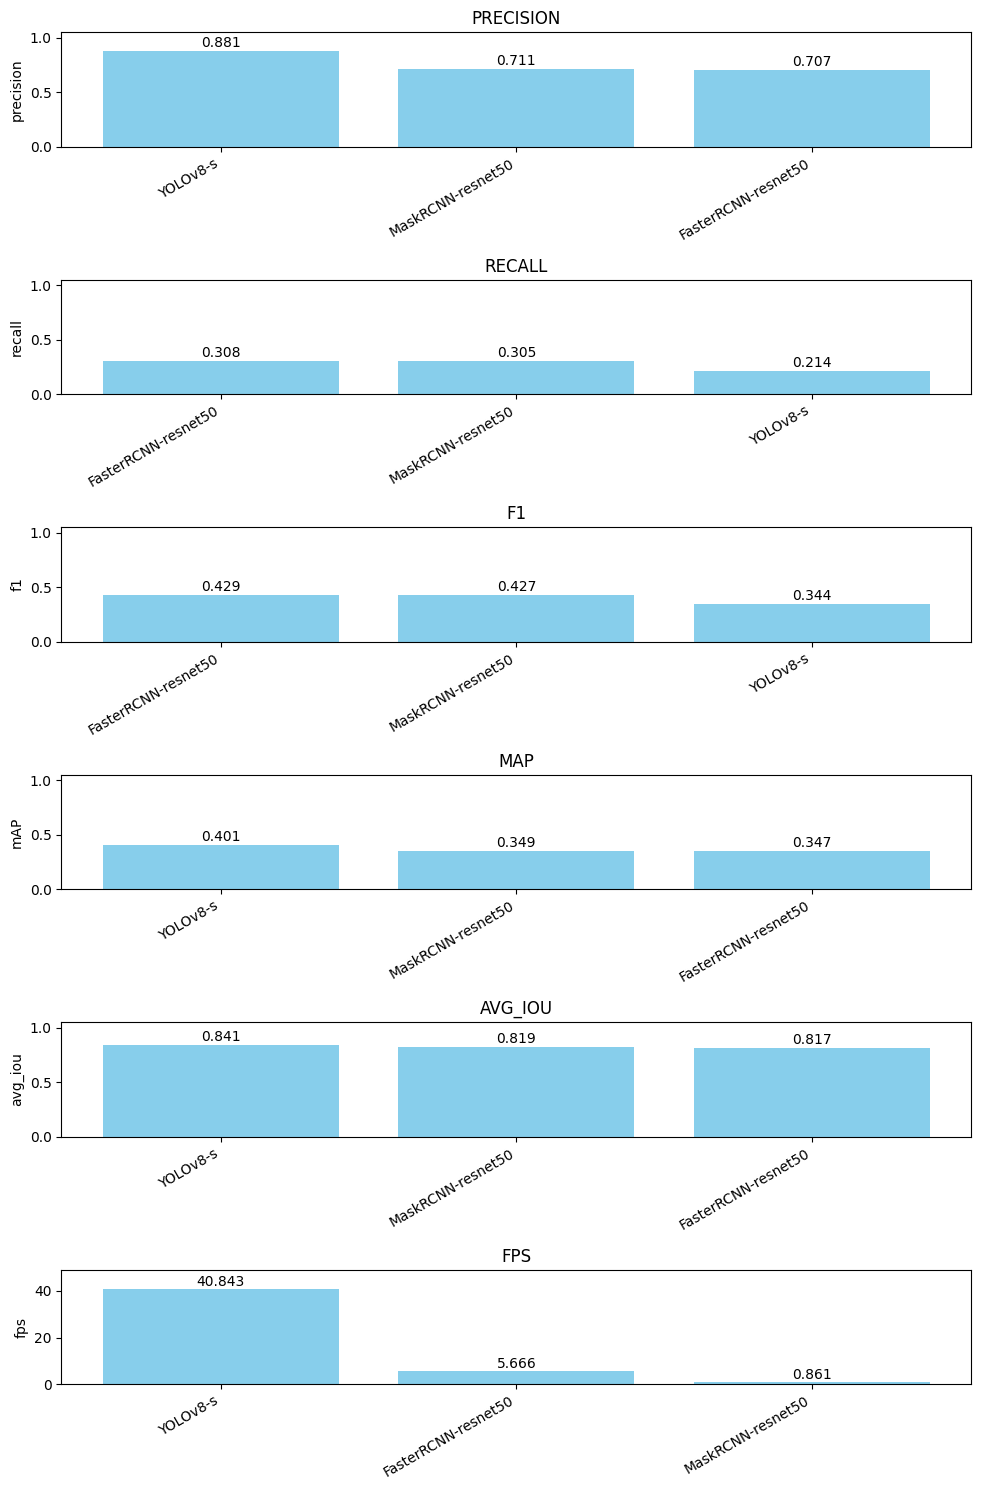

In [ ]:
def plot_metrics_comparison(summary_df):
    """
    Create bar charts comparing metrics across models
    """
    metrics = ['precision', 'recall', 'f1', 'mAP', 'avg_iou', 'fps']

    # Create a figure with subplots
    fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 15))

    for i, metric in enumerate(metrics):
        # Sort by metric value
        sorted_df = summary_df.sort_values(metric, ascending=False)

        # Create bar chart
        bars = axes[i].bar(sorted_df.index, sorted_df[metric], color='skyblue')

        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                         f'{height:.3f}', ha='center', va='bottom')

        # Set labels and title
        axes[i].set_title(f'{metric.upper()}')
        axes[i].set_ylabel(metric)

        # Set y-limit
        if metric != 'fps':
            axes[i].set_ylim(0, 1.05)
        else:
            axes[i].set_ylim(0, sorted_df['fps'].max() * 1.2)

        # Rotate x-axis labels
        plt.setp(axes[i].get_xticklabels(), rotation=30, ha='right')

    plt.tight_layout()

    # Save figure
    fig_path = os.path.join(results_path, 'visualizations', 'metrics_comparison.png')
    plt.savefig(fig_path)

    return fig

# Plot metrics comparison
metrics_fig = plot_metrics_comparison(summary_df)
plt.show()

**Step 13: Per-Frame FPS Analysis**

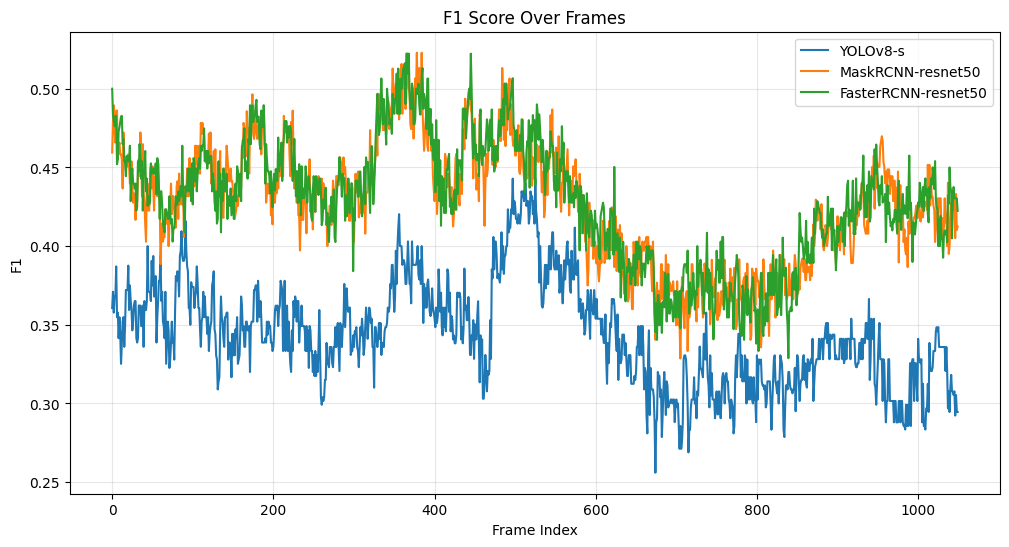

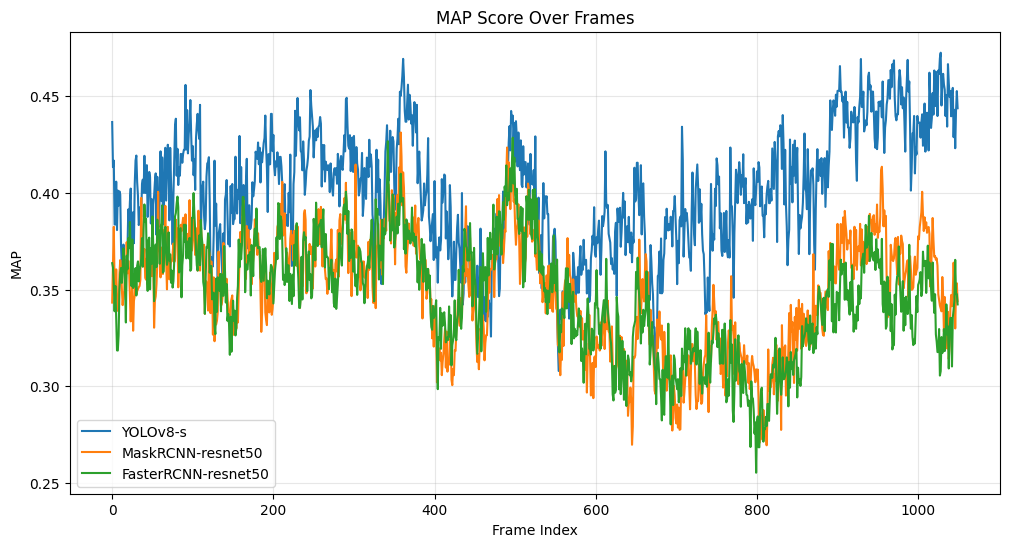

In [ ]:
def plot_per_frame_metrics(full_results, metric='f1'):
    """
    Plot metrics for each frame to analyze performance over time
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    for detector_name, metrics in full_results.items():
        if metrics[metric]:
            ax.plot(metrics[metric], label=detector_name)

    ax.set_xlabel('Frame Index')
    ax.set_ylabel(metric.upper())
    ax.set_title(f'{metric.upper()} Score Over Frames')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Save figure
    fig_path = os.path.join(results_path, 'visualizations', f'per_frame_{metric}.png')
    plt.savefig(fig_path)

    return fig

# Plot F1 scores over frames
f1_fig = plot_per_frame_metrics(full_results, metric='f1')
plt.show()

# Plot mAP scores over frames
map_fig = plot_per_frame_metrics(full_results, metric='mAP')
plt.show()

**Step 14: Find the Best Model**

Generating model comparison
Input summary data:
                     precision  recall      f1     mAP  avg_iou  \
YOLOv8-s                0.8812  0.2144  0.3438  0.4015   0.8408   
MaskRCNN-resnet50       0.7106  0.3054  0.4268  0.3492   0.8190   
FasterRCNN-resnet50     0.7074  0.3084  0.4291  0.3468   0.8165   

                     avg_processing_time      fps  
YOLOv8-s                          0.0245  40.8428  
MaskRCNN-resnet50                 1.1612   0.8612  
FasterRCNN-resnet50               0.1765   5.6662  

Raw comparison table with rankings:
                     precision  recall      f1     mAP  avg_iou  \
YOLOv8-s                0.8812  0.2144  0.3438  0.4015   0.8408   
MaskRCNN-resnet50       0.7106  0.3054  0.4268  0.3492   0.8190   
FasterRCNN-resnet50     0.7074  0.3084  0.4291  0.3468   0.8165   

                     avg_processing_time      fps  precision_rank  \
YOLOv8-s                          0.0245  40.8428             1.0   
MaskRCNN-resnet50              

,Precision,Recall,F1 Score,mAP,Avg IoU,FPS,Overall Rank
YOLOv8-s,0.881200,0.214400,0.343800,0.401500,0.840800,40.842800,1.666700
MaskRCNN-resnet50,0.710600,0.305400,0.426800,0.349200,0.819000,0.861200,2.166700
FasterRCNN-resnet50,0.707400,0.308400,0.429100,0.346800,0.816500,5.666200,2.166700


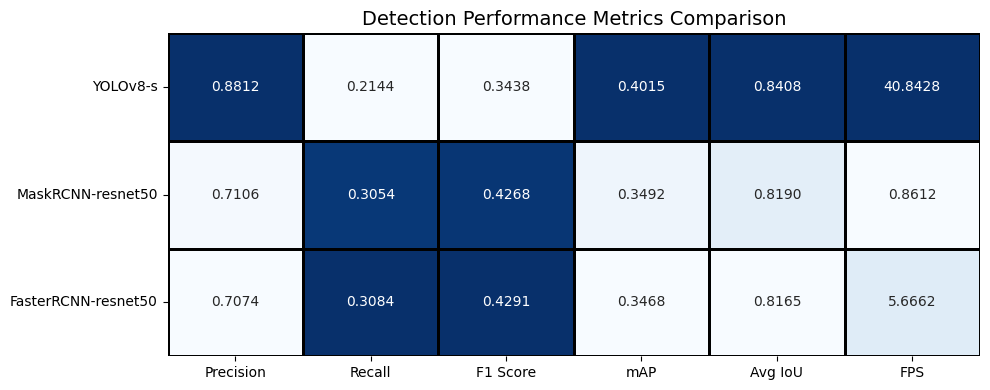

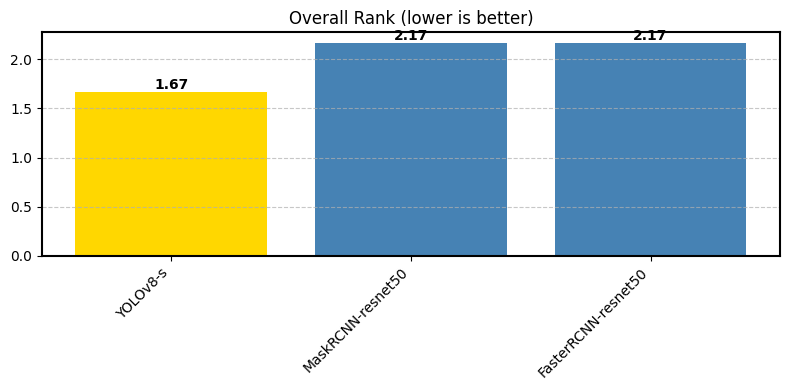


MODEL SELECTION RATIONALE: YOLOv8-s

Based on the evaluation across six key metrics (Precision, Recall, F1 Score, mAP,
Average IoU, and processing speed), the YOLOv8-s model demonstrates the best overall
performance with an Overall Rank of 1.67.

This model achieved:
- Precision: 0.8812
- Recall: 0.2144
- F1 Score: 0.3438
- mAP: 0.4015
- Average IoU: 0.8408
- Processing Speed: 40.84 FPS


Best model for project report: YOLOv8-s


In [ ]:
# Step 16: Compare and rank detector performance

from IPython.display import display, HTML
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_comparison_table(summary_df):
    """
    Create a comparison table with rankings for all 6 metrics
    """
    # Clone the summary dataframe
    comparison_table = summary_df.copy()

    # Make sure the DataFrame has all required columns
    required_columns = ['precision', 'recall', 'f1', 'mAP', 'avg_iou', 'fps']
    for col in required_columns:
        if col not in comparison_table.columns:
            raise ValueError(f"Missing required column: {col}")

    # Define all metrics to rank (higher is better for all metrics)
    rank_metrics = ['precision', 'recall', 'f1', 'mAP', 'avg_iou', 'fps']

    # Create ranks for each metric (ascending=False means that higher values get lower ranks)
    for metric in rank_metrics:
        comparison_table[f'{metric}_rank'] = comparison_table[metric].rank(ascending=False)

    # Calculate overall rank (average of individual ranks)
    comparison_table['overall_rank'] = comparison_table[[f'{m}_rank' for m in rank_metrics]].mean(axis=1)

    # Sort by overall rank (lower is better)
    comparison_table = comparison_table.sort_values('overall_rank')

    return comparison_table

def create_report_tables(comparison_table, results_path=None):
    """
    Generate formatted tables - Colab-friendly version with improved styling
    """
    # Create a display dataframe
    display_cols = ['precision', 'recall', 'f1', 'mAP', 'avg_iou', 'fps', 'overall_rank']
    display_df = comparison_table[display_cols].copy()

    # Rename columns for readability
    readable_names = {
        'precision': 'Precision',
        'recall': 'Recall',
        'f1': 'F1 Score',
        'mAP': 'mAP',
        'avg_iou': 'Avg IoU',
        'fps': 'FPS',
        'overall_rank': 'Overall Rank'
    }
    display_df.rename(columns=readable_names, inplace=True)

    # Sort by overall rank
    display_df = display_df.sort_values('Overall Rank')

    # Display as a regular DataFrame with better styling
    print("\nModel Comparison Table:")

    # Apply styling to highlight best overall rank
    def highlight_min(s):
        if s.name == 'Overall Rank':
            is_min = s == s.min()
            return ['background-color: gold' if v else '' for v in is_min]
        else:
            return ['' for v in s]

    # Style with borders and highlighting
    styled_df = display_df.round(4).style.set_properties(**{
        'border': '1px solid black',
        'color': 'black',
        'padding': '8px',
        'text-align': 'center'
    }).apply(highlight_min)

    display(styled_df)

    # Create an improved heatmap with better color contrast
    plt.figure(figsize=(10, len(display_df) + 1))

    # Normalize each column separately for better visualization
    heatmap_df = display_df.drop('Overall Rank', axis=1).copy()

    # Create a normalized version for visualization
    normalized_df = pd.DataFrame(index=heatmap_df.index, columns=heatmap_df.columns)

    # Normalize each column to 0-1 range
    for col in heatmap_df.columns:
        col_min = heatmap_df[col].min()
        col_max = heatmap_df[col].max()
        if col_max > col_min:
            normalized_df[col] = (heatmap_df[col] - col_min) / (col_max - col_min)
        else:
            normalized_df[col] = 0.5

    # Create a heatmap with the normalized values but display original values
    sns.heatmap(normalized_df, annot=heatmap_df.round(4), cmap="Blues", fmt=".4f",
                linewidths=1.0, linecolor='black', cbar=False)
    plt.title("Detection Performance Metrics Comparison", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Show Overall Rank separately
    plt.figure(figsize=(8, 4))
    ax = plt.gca()

    # Use different colors for bars - gold for best, blue for others
    bar_colors = ['gold' if val == display_df['Overall Rank'].min() else 'steelblue'
                 for val in display_df['Overall Rank']]

    bars = plt.bar(display_df.index, display_df['Overall Rank'], color=bar_colors)
    plt.title('Overall Rank (lower is better)')
    plt.xticks(rotation=45, ha='right')

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

    # Add gridlines and border
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

    plt.tight_layout()
    plt.show()

    # Return the best model name
    return display_df['Overall Rank'].idxmin()

def generate_model_comparison_report(summary_df, results_path=None):
    """
    Main function to generate model comparison
    """
    print("Generating model comparison")

    # Print raw input for debugging
    print("Input summary data:")
    print(summary_df.round(4))

    # Create the comparison table with rankings
    comparison_table = create_comparison_table(summary_df)

    # Print raw comparison table
    print("\nRaw comparison table with rankings:")
    print(comparison_table.round(4))

    # Create formatted tables and get the best model
    best_model = create_report_tables(comparison_table, results_path)

    # Generate explanation text
    print("\n" + "="*80)
    print(f"MODEL SELECTION RATIONALE: {best_model}")
    print("="*80)

    explanation = f"""
Based on the evaluation across six key metrics (Precision, Recall, F1 Score, mAP,
Average IoU, and processing speed), the {best_model} model demonstrates the best overall
performance with an Overall Rank of {comparison_table.loc[best_model, 'overall_rank']:.2f}.

This model achieved:
- Precision: {comparison_table.loc[best_model, 'precision']:.4f}
- Recall: {comparison_table.loc[best_model, 'recall']:.4f}
- F1 Score: {comparison_table.loc[best_model, 'f1']:.4f}
- mAP: {comparison_table.loc[best_model, 'mAP']:.4f}
- Average IoU: {comparison_table.loc[best_model, 'avg_iou']:.4f}
- Processing Speed: {comparison_table.loc[best_model, 'fps']:.2f} FPS
"""

    print(explanation)
    print("="*80)

    return best_model, comparison_table

# Execute the comparison
best_model, comparison_table = generate_model_comparison_report(summary_df)

print(f"\nBest model for project report: {best_model}")

**Step 15: Create video for the best model**

In [ ]:
def create_detection_video(frames, frame_ids, detector, gt_file, frame_width, frame_height, output_path):
    """
    Create a video showing detections with object labels
    """
    # Create output directory
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # Get video properties
    height, width, _ = frames[0].shape
    fps = 30

    # Class name mapping for COCO dataset
    class_names = {
        0: 'background',
        1: 'person',
        2: 'bicycle',
        3: 'car',
        4: 'motorcycle',
        5: 'airplane',
        6: 'bus',
        7: 'train',
        8: 'truck',
        9: 'boat',
        10: 'traffic light',
        11: 'fire hydrant',
        12: 'stop sign',
        13: 'parking meter',
        14: 'bench',
        15: 'bird',
        16: 'cat',
        17: 'dog',
        18: 'horse',
        19: 'sheep',
        20: 'cow',
        21: 'elephant',
        22: 'bear',
        23: 'zebra',
        24: 'giraffe',
        25: 'backpack',
        26: 'umbrella',
        27: 'handbag',
        28: 'tie',
        29: 'suitcase',
        30: 'frisbee',
        31: 'skis',
        32: 'snowboard',
        33: 'sports ball',
        34: 'kite',
        35: 'baseball bat',
        36: 'baseball glove',
        37: 'skateboard',
        38: 'surfboard',
        39: 'tennis racket',
        40: 'bottle',
        41: 'wine glass',
        42: 'cup',
        43: 'fork',
        44: 'knife',
        45: 'spoon',
        46: 'bowl',
        47: 'banana',
        48: 'apple',
        49: 'sandwich',
        50: 'orange',
        51: 'broccoli',
        52: 'carrot',
        53: 'hot dog',
        54: 'pizza',
        55: 'donut',
        56: 'cake',
        57: 'chair',
        58: 'couch',
        59: 'potted plant',
        60: 'bed',
        61: 'dining table',
        62: 'toilet',
        63: 'tv',
        64: 'laptop',
        65: 'mouse',
        66: 'remote',
        67: 'keyboard',
        68: 'cell phone',
        69: 'microwave',
        70: 'oven',
        71: 'toaster',
        72: 'sink',
        73: 'refrigerator',
        74: 'book',
        75: 'clock',
        76: 'vase',
        77: 'scissors',
        78: 'teddy bear',
        79: 'hair drier',
        80: 'toothbrush'
    }

    # Debug info
    print(f"Creating video: {width}x{height} at {fps} FPS")
    print(f"Total frames: {len(frames)}")
    print(f"This may take several minutes. Please wait...")

    try:
        # Initialize video writer with compatible code
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        if not out.isOpened():
            print(f"Error: Video writer could not be opened for {output_path}")
            # Try alternative codec
            fourcc = cv2.VideoWriter_fourcc(*'MJPG')
            out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
            print("Attempting with MJPG codec instead")

        for frame, frame_id in zip(frames, frame_ids):
            # Create a copy of the frame for drawing
            vis_frame = frame.copy()

            # Get ground truth for current frame
            ground_truths = parse_ground_truth(gt_file, frame_id, frame_width, frame_height)

            # Get detections for this frame
            detections = detector.detect(frame)

            # Draw all detections with labels
            for det in detections:
                # Unpack detection: [x1, y1, x2, y2, class_id, confidence]
                x1, y1, x2, y2, class_id, conf = det

                # Convert coordinates to integers
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

                # Get class name
                class_name = class_names.get(int(class_id), f'class_{int(class_id)}')

                # Create label with class name and confidence
                label = f"{class_name}: {conf:.2f}"

                # Choose color based on class_id for consistent colors
                color_r = (int(class_id * 35) % 255)
                color_g = (int(class_id * 60) % 255)
                color_b = (int(class_id * 120) % 255)
                box_color = (color_b, color_g, color_r)  # BGR format for OpenCV

                # Draw bounding box
                cv2.rectangle(vis_frame, (x1, y1), (x2, y2), box_color, 2)

                # Draw label background
                text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
                cv2.rectangle(vis_frame, (x1, y1 - text_size[1] - 5), (x1 + text_size[0], y1), box_color, -1)

                # Draw label text
                cv2.putText(vis_frame, label, (x1, y1 - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

            # Add frame info
            cv2.putText(vis_frame, f"Frame: {frame_id}", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            # Add model info
            cv2.putText(vis_frame, f"Model: {detector.name}", (10, 70),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            # Add detection count
            cv2.putText(vis_frame, f"Objects detected: {len(detections)}", (10, 110),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            # Write frame to video
            out.write(vis_frame)

        # Explicitly release resources
        out.release()

        # Check if the file was created and has content
        if os.path.exists(output_path) and os.path.getsize(output_path) > 0:
            print(f"Video saved successfully to {output_path}")
            print(f"Video file size: {os.path.getsize(output_path) / (1024 * 1024):.2f} MB")
        else:
            print(f"Warning: Video file is empty or not created at {output_path}")

    except Exception as e:
        print(f"Error creating video: {e}")
    finally:
        # Ensure resources are released even if an error occurs
        if 'out' in locals() and out is not None:
            out.release()

# Path to the best model's video
best_model_video_path = os.path.join(results_path, 'videos', f"{selected_seq}_{best_model}.mp4")
print(f"Best model video saved at: {best_model_video_path}")

# Define the detectors
detectors = [yolo_detector, maskrcnn_detector, fasterrcnn_detector]

# Get the best model's detector
best_detector = None
for detector in detectors:
    if detector.name == best_model:
        best_detector = detector
        break

if best_detector is None:
    print(f"Error: Could not find detector object for best model {best_model}")
else:
    print(f"Creating video for best model: {best_model}")
    print("This may take several minutes. Please wait...")

# Create video for the best model
if best_detector is not None and 'frames' in locals() and 'frame_ids' in locals() and 'gt_file' in locals():
    try:
        create_detection_video(
            frames=frames,
            frame_ids=frame_ids,
            detector=best_detector,
            gt_file=gt_file,
            frame_width=frame_width,
            frame_height=frame_height,
            output_path=best_model_video_path
        )
        print(f"Video creation completed for {best_model}")
    except Exception as e:
        print(f"Error creating video for best model: {e}")
else:
    print("Cannot create video: Missing required variables (frames, frame_ids, or gt_file)")

Best model video saved at: /content/ObjectDetectionProject/results/videos/MOT17-04_YOLOv8-s.mp4
Creating video for best model: YOLOv8-s
This may take several minutes. Please wait...
Creating video: 1920x1080 at 30 FPS
Total frames: 1050
This may take several minutes. Please wait...

0: 384x640 23 persons, 1 car, 1 motorcycle, 19.6ms
Speed: 4.7ms preprocess, 19.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 24 persons, 1 bicycle, 1 car, 1 motorcycle, 1 backpack, 11.8ms
Speed: 4.2ms preprocess, 11.8ms inference, 4.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 23 persons, 1 bicycle, 1 car, 1 motorcycle, 1 backpack, 16.3ms
Speed: 3.7ms preprocess, 16.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 26 persons, 1 car, 1 motorcycle, 1 backpack, 1 potted plant, 13.0ms
Speed: 3.7ms preprocess, 13.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 24 persons, 2 bicycles, 1 car, 1 mo

## **References**

Class mappings from the COCO dataset
Reference: Lin, T. Y., et al. (2014). Microsoft COCO: Common Objects in Context. ECCV 2014.

MOT16: A Benchmark for Multi-Object Tracking.
Anton Milan, Laura Leal-Taixé, Ian Reid, Stefan Roth, Konrad Schindler.
arXiv:1603.00831
article{MOT16,
	title = {{MOT}16: {A} Benchmark for Multi-Object Tracking},
	shorttitle = {MOT16},
	url = {http://arxiv.org/abs/1603.00831},
	journal = {arXiv:1603.00831 [cs]},
	author = {Milan, A. and Leal-Taix\'{e}, L. and Reid, I. and Roth, S. and Schindler, K.},
	month = mar,
	year = {2016},
	note = {arXiv: 1603.00831},
	keywords = {Computer Science - Computer Vision and Pattern Recognition}
}

YOLOv8: Ultralytics (https://github.com/ultralytics/ultralytics)

Faster R-CNN: Ren et al. (2015)

Mask R-CNN: He et al. (2017)
